# 01 데이터 분석 순서

1. 데이터 수집
2. 데이터 탐색
3. 데이터 전처리 
4. 모델링 with train data
5. 평가 with test data 

cf. 절대로 모델링 과정에서 테스트 데이터 사용 금지!

# 02 분류 성능 평가 지표

## 정확도(Accuracy)

In [2]:
# 정확도; 예측이 실제와 얼마나 같은지
# 정확도 = 예측 성공 / 전체 예측
# 이진분류의 경우, 정확도만으로는 모델 성능 왜곡 가능성 존재

In [ ]:
# 정확도 지표의 한계점(1); 단순한 알고리즘
import numpy as np
import pandas as pd
import seaborn as sns

# telecom; 통신사 이탈률 자료(이진분류 문제)
telecom = pd.read_csv('C:/Users/USER/BITAmin/data/telecom_churn.csv')

In [5]:
# 'international plan'과 'churn' 변수 간 관계 알아보기
telecom.groupby(['international plan', 'churn'])['churn'].count()

international plan  churn
no                  False    2664
                    True      346
yes                 False     186
                    True      137
Name: churn, dtype: int64

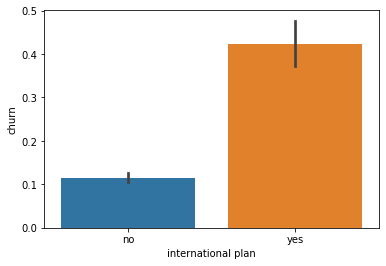

In [7]:
# 'international plan'을 이용하는 고객이 이용하지 않는 고객보다 이탈 가능성 큼
sns.barplot(x='international plan', y='churn', data=telecom)

In [8]:
telecom['churn'] = telecom['churn'].apply(lambda x: 1 if x==True else 0)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

In [12]:
# 사이킷런의 BaseEsimator을 상속받아 아무런 학습을 하지 않는 단순한 Classifier
class MyDummyClassifier(BaseEstimator):
    def fit(self,  X, y=None): # fit; 아무것도 학습하지 않음
        pass
    def predict(self, X): # predict; 단순 예측
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['international plan'].iloc[i] == 'no':
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [16]:
# 데이터 가공 및 학습 데이터와 테스트 데이터 분할
X = telecom.drop('churn', axis=1)
y = telecom['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [18]:
# 앞에서 생성한 Dummy Classifier를 이용해 학습, 예측, 평가
# 즉, 단순한 알고리즘으로 예측을 수행해도 데이터 구성에 따라 정확도가 높게 나타날 수 있음
# 따라서 평가 지표로 사용할 때는 신중해야함 

myclf = MyDummyClassifier() # 객체 생성
myclf.fit(X_train, y_train) # 학습
mypredictions= myclf.predict(X_test) # 예측
print('Dummy Classifier의 정확도: {0:.4f}'.format(accuracy_score(y_test, mypredictions))) # 평가 

Dummy Classifier의 정확도: 0.8216


In [19]:
# 정확도 지표의 한계점(2); 불균형 데이터
# 불균형한 데이터셋에 극단적인 예측 classifier를 적용해도 높은 정확도를 나타낼 수 있음
# 즉, 특정한 결과로 찍어도 높은 정확도 수치가 나타날 수 있다는 맹점 존재 

telecom.churn.value_counts() 

0    2850
1     483
Name: churn, dtype: int64

In [28]:
# 입력값으로 들어오는 X 데이터셋의 크기만큼 모두 0으로 만들어서 반환하는 Classifier 생성
class MyFakeClassifier(BaseEstimator):
    def fit(Self, X, y):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [29]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트셋 크기:', y_test.shape)
print('테스트셋 레이블의 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

레이블 테스트셋 크기: (667,)
테스트셋 레이블의 0과 1의 분포도
0    569
1     98
Name: churn, dtype: int64


In [32]:
# predict() 결과를 모두 0으로 반환함에도 85%의 높은 정확도
# 즉, 불균현한 레이블 데이터셋에서는 성능 수치로 사용돼서는 안 됨

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 한 정확도: {:.3f}'.format(accuracy_score(y_test, fakepred)))

모든 예측을 0으로 한 정확도: 0.853


## 오차행렬(Confusion matrix, 혼동행렬)

In [ ]:
# 오차행렬; 학습된 분류모델이 예측을 수행하면서 얼마나 헷갈리고 있는지 보여주는 지표
# 이진분류의 예측오류가 얼마인지 + 어떠한 유형의 예측 오류가 발생하고 있는지 확인 가능
# T/F; 예측값과 실제값이 같은지 틀린지
# P/N; 예측결과가 부정인지 긍정인지

In [33]:
# 위의 MyFakeClassifier의 예측 성능 지표를 오차행렬로 표현해보기
# 이때, 출력된 오차행렬은 ndarray 형태
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[569,   0],
       [ 98,   0]], dtype=int64)

## 정밀도(Precision)와 재현율(Recall)

In [ ]:
# 데이터 기반 ML알고리즘은 negative로 예측 정확도가 높아지는 경향 존재
# 정밀도와 재현율; 정확도 지표만으로는 한계점 존재, 보완 필요
# 정밀도; 예측이 positive인 대상 중 실제도 positive인 데이터의 비율
# 재현율; 실제가 positive인 대상 중 예측도 positive인 데이터의 비율

In [37]:
# 정밀도; precision_score() 이용
# 재현율; recall_score() 이용

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 평가를 한꺼번에 수행하는 함수 정의
def get_clf_eval(y_test, pred): 
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도 : {:.4f}\n정밀도 : {:.4f}\n재현율 : {:.4f}'.format(accuracy, precision, recall))
    
# 데이터 전처리 관련 함수 정의

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace  = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1 , inplace = True)
    return df

# 레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df    

In [38]:
# 로지스틱 회귀 기반으로 타이타닉 생존자를 예측 후 평가 수행
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('C:/Users/USER/BITAmin/data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492
정밀도 : 0.7742
재현율 : 0.7869


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 정밀도와 재현율의 Trade-off

In [39]:
# 분류의 결정 임계값(Threshold)을 조정해 정밀도 또는 재현율 수치 조정
# predict_proba(); 사이킷런에서 개별 데이터별로 예측 확률을 반환하는 메서드

# 타이타닉  생존자 데이터에서 predict() 결과 값과 predict_proba() 결과 값을 비교
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print('pred_proba의 shape: {0}'.format(pred_proba.shape))
print('pred_proba의 array에서 앞 3개만 샘플로 추출 :\n', pred_proba[:3])

#예측확률 array와 예측 결과값 array를 병합하여 예측확률과 결괏값을 한 번에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba의 shape: (179, 2)
pred_proba의 array에서 앞 3개만 샘플로 추출 :
 [[0.46175211 0.53824789]
 [0.87863924 0.12136076]
 [0.87717092 0.12282908]]
두 개의 class 중 더 큰 확률을 클래스 값으로 예측
 [[0.46175211 0.53824789 1.        ]
 [0.87863924 0.12136076 0.        ]
 [0.87717092 0.12282908 0.        ]]


In [40]:
# Binarizer 클래스; 입력된 ndarray의 값을 지정된 threshold보다 같거나 작으면 0, 크면 1로 변환해 반환

from sklearn.preprocessing import Binarizer

# 예; 넘파이 ndarray 값 입력
X = [[-1, -1, 2],
        [2, 0, 0], 
        [0, 1.1, 1.2]]

# X의 개별원소들이 threshold보다 크면 1, 작거나 같으면 0을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [41]:
# 분류 결정 임계값 0.5 설정 후 Binarizer을 이용하여 예측값 변환

# Binarizer의 threshold 값을 0.5로 설정
custom_threshold = 0.5

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492
정밀도 : 0.7742
재현율 : 0.7869


In [42]:
# 분류 결정 임계값을 낮추면? 0.5 -> 0.4
# 재현율은 높아지고 정밀도는 떨어짐을 확인할 수 있음

# Binarizer의 threshold 값을 0.4로 설정
custom_threshold = 0.4

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[98 20]
 [10 51]]
정확도 : 0.8324
정밀도 : 0.7183
재현율 : 0.8361


In [43]:
# 임계값을 증가시키며 평가 지표 조사
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

# 평가지표를 조사하기 위한 새로운 함수 생성
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 iteration 하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임계값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임계값:  0.4
오차행렬
[[98 20]
 [10 51]]
정확도 : 0.8324
정밀도 : 0.7183
재현율 : 0.8361

임계값:  0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492
정밀도 : 0.7656
재현율 : 0.8033

임계값:  0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492
정밀도 : 0.7742
재현율 : 0.7869

임계값:  0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659
정밀도 : 0.8364
재현율 : 0.7541

임계값:  0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771
정밀도 : 0.8824
재현율 : 0.7377


In [45]:
# 매번 우리가 위와 같은 함수를 만들 필요는 없음
# 사이킷런에서 precision_recall_curve() 제공!

from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 떄의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[ : , 1]

# 실제값 데이터 세트와 레이블 값이 1일 때 예측확률을 precision_recall_curve의 인자로 반환
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape: ', thresholds.shape)

# 반환된 임계값 배열 로우가 147건 이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 : ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 : ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 shape:  (143,)
샘플 추출을 위한 임계값 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도 :  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율 :  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


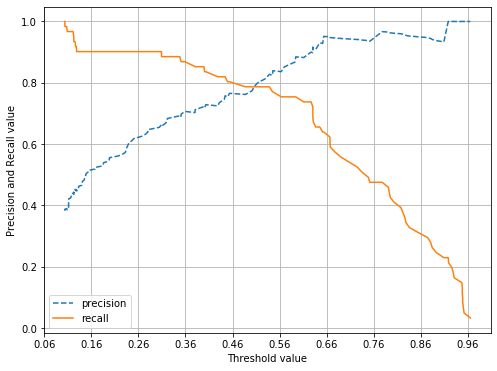

In [46]:
# 정밀도와 재현율의 임계값의 따른 변화를 곡선 형태의 그래프로 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold 값, y축을 정밀도, 재현율로 그리기
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

## F1 스코어

In [47]:
# F1 스코어; 정밀도와 재현율을 결합한 지표

from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {:.4f}'.format(f1))

F1 스코어 : 0.7805


In [48]:
# 임계값 변화에 따른 F1 스코어 평가 지표 확인

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # F1 score print 추가
    print('\n정확도: {:.4f}\n정밀도: {:.4f}\n재현율: {:.4f}\nF1: {:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임계값:  0.4
오차행렬
[[98 20]
 [10 51]]

정확도: 0.8324
정밀도: 0.7183
재현율: 0.8361
F1: 0.7727

임계값:  0.45
오차행렬
[[103  15]
 [ 12  49]]

정확도: 0.8492
정밀도: 0.7656
재현율: 0.8033
F1: 0.7840

임계값:  0.5
오차행렬
[[104  14]
 [ 13  48]]

정확도: 0.8492
정밀도: 0.7742
재현율: 0.7869
F1: 0.7805

임계값:  0.55
오차행렬
[[109   9]
 [ 15  46]]

정확도: 0.8659
정밀도: 0.8364
재현율: 0.7541
F1: 0.7931

임계값:  0.6
오차행렬
[[112   6]
 [ 16  45]]

정확도: 0.8771
정밀도: 0.8824
재현율: 0.7377
F1: 0.8036


## ROC 곡선과 AUC

In [49]:
# ROC 곡선; FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선

from sklearn.metrics import roc_curve

# 레이블 값이 1일 때 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열 로우가 47건이므로 샘플로 10건만 추출하되 임계값을 5step으로 추출
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 5 step으로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index 10개:  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임계값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임계값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임계값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


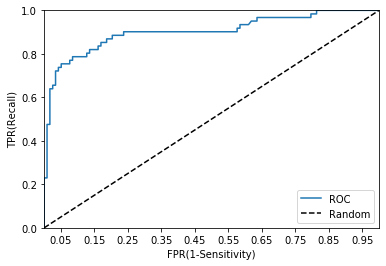

In [50]:
# ROC 곡선 시각화

def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값을반환 받음
    fprs, tprs, thresholds  = roc_curve(y_test, pred_proba_c1)
    # ROC곡선을 그래프로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

In [51]:
# 사이킷런의 API를 사용해 AUC값 구하기

from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값 : {:.4f}'.format(roc_score))

ROC AUC 값 : 0.8341


In [75]:
# 평가 지표 총정리 함수

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('\n정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nF1: {3:.4f}\nAUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 평가지표 실습

### 피마 인디언 당뇨병 데이터셋 구성
* Pregnancies : 임신횟수
* Glucose : 포도당 부하 검사 수치
* BloodPressure : 혈압
* SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값
* Insulin : 혈청 인슐린
* BMI : 체질량 지수
* DiabetesPedigreeFunction : 당뇨 내력 가중치 값
* Age : 나이
* Outcome : 당뇨여부(0 또는 1)

In [53]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [61]:
# 데이터 불러오기

diabetes_data = pd.read_csv('C:/Users/USER/BITAmin/data/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [62]:
# 데이터 정보 확인하기
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [76]:
# 피쳐 데이터 세트 X, 레이블 데이터 세트 y 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:, -1]

# 데이터를 훈련과 테스트 데이터 셋으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]

정확도: 0.7727
정밀도: 0.7209
재현율: 0.5741
F1: 0.6392
AUC: 0.7919


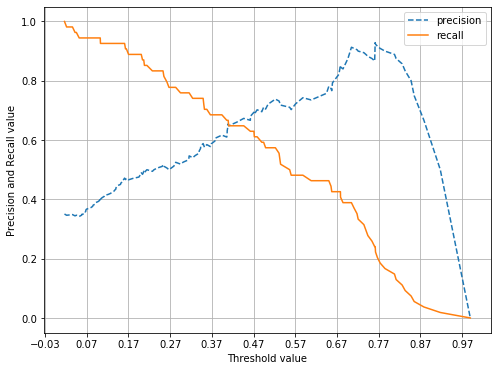

In [77]:
# 임계값별로 정밀도-재현율 출력; precision_recall_curve_plot() 이용
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba)

In [78]:
# 데이터 기초 통계량 확인
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

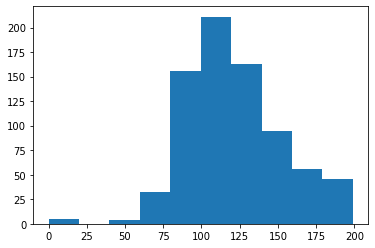

In [80]:
# 포도당 수치('Glucose')의 히스토그램 확인 -> 0값이 일정 수준 이상 존재
plt.hist(diabetes_data['Glucose'], bins=10)

In [81]:
# 0값을 검사할 피쳐명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터를 추출하고 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0}의 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose의 0 건수는 5, 퍼센트는 0.65%
BloodPressure의 0 건수는 35, 퍼센트는 4.56%
SkinThickness의 0 건수는 227, 퍼센트는 29.56%
Insulin의 0 건수는 374, 퍼센트는 48.70%
BMI의 0 건수는 11, 퍼센트는 1.43%


In [83]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균값으로 대체
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

In [86]:
# 데이터 세트에 대해 피처 스케일링을 적용하여 변환
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 상용하여 데이터 세트에 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=156, stratify = y)

# 로지스틱 회귀로 학습, 예측, 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train,  y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]

정확도: 0.7987
정밀도: 0.7674
재현율: 0.6111
F1: 0.6804
AUC: 0.8433


In [90]:
# get_eval_by_threshold() 함수 수정
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 iteration 하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임계값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [91]:
# 임계값 변화에 따른 예측 성능 확인
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임계값:  0.3
오차 행렬
[[67 33]
 [11 43]]

정확도: 0.7143
정밀도: 0.5658
재현율: 0.7963
F1: 0.6615
AUC: 0.8433

임계값:  0.33
오차 행렬
[[72 28]
 [12 42]]

정확도: 0.7403
정밀도: 0.6000
재현율: 0.7778
F1: 0.6774
AUC: 0.8433

임계값:  0.36
오차 행렬
[[76 24]
 [15 39]]

정확도: 0.7468
정밀도: 0.6190
재현율: 0.7222
F1: 0.6667
AUC: 0.8433

임계값:  0.39
오차 행렬
[[78 22]
 [16 38]]

정확도: 0.7532
정밀도: 0.6333
재현율: 0.7037
F1: 0.6667
AUC: 0.8433

임계값:  0.42
오차 행렬
[[84 16]
 [18 36]]

정확도: 0.7792
정밀도: 0.6923
재현율: 0.6667
F1: 0.6792
AUC: 0.8433

임계값:  0.45
오차 행렬
[[85 15]
 [18 36]]

정확도: 0.7857
정밀도: 0.7059
재현율: 0.6667
F1: 0.6857
AUC: 0.8433

임계값:  0.48
오차 행렬
[[88 12]
 [19 35]]

정확도: 0.7987
정밀도: 0.7447
재현율: 0.6481
F1: 0.6931
AUC: 0.8433

임계값:  0.5
오차 행렬
[[90 10]
 [21 33]]

정확도: 0.7987
정밀도: 0.7674
재현율: 0.6111
F1: 0.6804
AUC: 0.8433


In [93]:
# 임계값을 0.48로 설정하여 예측 수행
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 predict_proba() 예측확률의 array에서 1에 해당하는 컬럼 값을 대입하여 Binarizer 반환하기
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]

정확도: 0.7987
정밀도: 0.7447
재현율: 0.6481
F1: 0.6931
AUC: 0.8433


# 03 회귀 성능 평가 지표

## MAE

* 실제값과 예측값의 차이를 절대값으로 반환한 평균
* 에러의 절대값 그 자체를 나타내기 때문에 작을수록 좋음
* 장점: 지표 자체가 직관적이며 예측변수와 단위가 같음
* 단점: 실제값에 대해 과소/과대추정 파악 어렵, 스케일에 의존적

## MSE

* 실제값과 예측값의 차이를 제곱한 것의 평균 = 잔차 제곱의 평균
* 장점: 지표 자체가 직관적임
* 단점: 과소/과대추정 파악 어렵, 예측변수와 단위가 다름, 잔차를 제곱하기 때문에 이상치에 민감 등

## RMSE

* MSE에 루트를 씌운 값: MSE는 오류의 제곱이므로 실제 오류의 평균보다 커지는 특성이 있음
* 장점: 지표가 직관적이며 예측변수와 단위가 같음, 잔차를 제곱하면서 생기는 왜곡이 MSE보다 작음
* 단점: 과소/과대추정 파악 어렵, 스케일에 의존적

## MAPE

* MAE를 비율(%)로 표현한 값
* 장점: 비율 변수이므로 성능 비교가 용이함
* 단점: 과소/과대추정 파악 어렵, 비율 해석이 유의미한 경우에만 적용 가능, 실제값에 0이 포함될 경우 계산 불가

## MPE

* MAPE에서 절대값을 제외한 값
* 장점: 실제값에 대해 과소/과대추정 파악이 가능
* MPE > 0: underestimates
* MPE < 0: overestimates

# 04 비지도학습 성능 평가 지표

* 군집 타당성 지표 이용
- 고려할 점:
1) 군집간 거리
2) 군집의 지름
3) 군집의 분산

- 방법:
1) Dunn Index
2) Silhouette

## Dunn Index

* 분자: 군집 간 거리의 최소값
* 분모: 군집 내 요소 간 거리의 최대값

## Silhouette

* 군집 내의 샘플이 얼마나 결합력 잇게 그룹화 되었는지 수량화하여 평가